# Classifiez automatiquement des biens de consommation
 1ere partie : EDA NLP manuel  - CountVectorizer et TF-IDF
Mission
Ta mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

Tu dois analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering. Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters. Ces résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

Pourrais-tu nous démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des produits de même catégorie ?

Voici les contraintes : 

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
une approche de type word/sentence embedding avec BERT ;
une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 

# Import

In [1]:
import os, sys, time, random
import pandas as pd
import numpy as np

import os
import random
import re #Opération de base sur les expressions rationnelles
import string

#NLP
import nltk
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, wordpunct_tokenize
#from nltk import clean_html
# Lemmatizer (base d'un mot)
from nltk import chunk 
from nltk.corpus import words
from nltk.corpus import stopwords

from nltk.stem import *
from nltk.stem import PorterStemmer
from nltk.util import clean_html


#Viz - Représentation graphique
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

#Exécuter le code sur plusieurs CPU pour gagener du temps
from pandarallel import pandarallel

import re #regex library expressions régulières

from sklearn import preprocessing

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, pairwise
from sklearn.metrics.pairwise import distance_metrics

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

from sklearn import preprocessing, decomposition, manifold, metrics, datasets, cluster
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import adjusted_rand_score

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.feature_extraction.text import CountVectorizer

#nltk.download("stopwords")
#nltk.download("punkt")
#!pip install gtts

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [2]:
from P6_NLP_functions import *
#Relancer le noyau Anaconda qd on crée la fct pour la 1ere fois

In [3]:
#Initialiser pandarallel pour travailler sur 6 CPU
pandarallel.initialize(progress_bar=True, 
                       nb_workers=6
                      # verbose=1
                      )

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Setting pandas display and matplotlib options.

In [4]:
# to show more cells while displaying pandas dataframe
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

# to set the figures background to white
plt.rcParams['figure.facecolor']='w'

To play audio text-to-speech during execution.

Graphic and option

In [5]:
sns.set()

## Objectifs du 27/01:
1- Concaténer nom Produit et Description.Pourquoi? En concaténant, on se retrouve avec des tokens en double    
Catégoire 1 : Nb de classe par produit
150 prd/ classe : Un bon équilibre de classe pour ne déséquilibrer l'analyse et les algorithmes

2-Métode Count Vectorizer 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Descrption/Bow : récupérer les descriptions les vectoriser avec contvectoriser et stocker dans X

Category ce sont les clusters qu'on va essayer de reproduire : label à encoder réprésenter Babay vecteur (1, 0, , 0, ..), santé (0,1, ..) à stocker ds y et à prédire. ce sont les clustrs réel,

3 - Utiliser le KMeans pour  prédire

Prendre Le Kmenas K = 7 - travailler le Kmeans avec 7 et récuperer les clusters de 0 à 6 artificiels.

4 - Comparer les vecteurs artificiels aux vecteurs réels avec ARI
Conclure à quel point le Kmeans est arrivé à produire le réel.

5- Visualiser avec TSNE

Répartitions à analyser
----------------------------------------

2e méthode TF IDF à utliser et qui doit produire de meielleurs résultats que CountVectoriser
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Refaire idem que la méthode du CountVectorizer
----------------------------------------*

3e méthode : 
Word2vec
https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/

-----------------------------------------------------------------
4e méthode : BERT
https://techblog.assignar.com/how-to-use-bert-sentence-embedding-for-clustering-text/

Spacy
https://spacy.io/usage/spacy-101

Il faut comprendre cette vidéo la rupture entre les stats et l'embedding senss global 
https://www.youtube.com/watch?v=CsQNF9s78Nc&ab_channel=ScienceEtonnante

https://spacy.io/usage/spacy-101

Il faut comprendre cette vidéo la rupture entre les stats et l'embedding senss global
https://www.youtube.com/watch?v=CsQNF9s78Nc&ab_channel=ScienceEtonnante

Pourquoi concaténer le nom produit avec la description. Le nom est souvent présent dans la description : 
Comment transformer 7 colonnes catégories en 1 seule target? Faut-il segmenter avant? ou les nommer 1, 2 ..7
Une fois vectorié que faire dans l'ordre

Ne pas filtrer mots anglais et ni les alphas

We have to predict tweet if disaster predict 1 else 0

# Data Assessment

In [6]:
path = 'C:/Users/ADSL/Documents/Projet 6/datas/' # 
data= pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

In [7]:
data.shape

(1050, 14)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 55b85ea15a1536d46b7190ad6fff8ce7 to f2f027ad6a6df617c9f125173da71e44
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   crawl_timestamp          1050 non-null   object 
 1   product_url              1050 non-null   object 
 2   product_name             1050 non-null   object 
 3   product_category_tree    1050 non-null   object 
 4   pid                      1050 non-null   object 
 5   retail_price             1049 non-null   float64
 6   discounted_price         1049 non-null   float64
 7   image                    1050 non-null   object 
 8   is_FK_Advantage_product  1050 non-null   bool   
 9   description              1050 non-null   object 
 10  product_rating           1050 non-null   object 
 11  overall_rating           1050 non-null   object 
 12  brand                    712 non-null    object 
 13  product_specifications  

In [9]:
data.head()

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
uniq_id,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.00,899.00,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value..."
7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...",BTWEGFZHGBXPHZUH,600.00,449.00,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""val..."
64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""valu..."
d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...",BDSEJT9UQWHDUBH4,2699.00,1299.00,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine ..."
6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...,Jaipur Print Cotton Floral King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...",BDSEJTHNGWVGWWQU,2599.00,698.00,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...",No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Brand"", ""value""..."


In [10]:
data.sample(5)

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
uniq_id,,,,,,,,,,,,,,
833a87b0af3b84fe246d2ebf271af177,2015-12-01 06:13:00 +0000,http://www.flipkart.com/zyxel-pla-4205/p/itmdyzydwztvmdf8?pid=RTRDYZYDXGHXXJNZ,Zyxel PLA-4205,"[""Computers >> Network Components >> Routers >> Zyxel Routers""]",RTRDYZYDXGHXXJNZ,10999.00,8100.00,833a87b0af3b84fe246d2ebf271af177.jpg,False,Buy Zyxel PLA-4205 only for Rs. 8100 from Flipkart.com. Only Genuine Products. 30 Day Replacemen...,No rating available,No rating available,Zyxel,"{""product_specification""=>[{""key""=>""In The Box"", ""value""=>""Router, Power Adapter, Manual""}, {""ke..."
55195de3873fffaa9e37b041533d7305,2015-12-31 09:19:31 +0000,http://www.flipkart.com/philips-9-5-w-led-b22-3000k-a55-ind-bulb/p/itmef3hhfzfzf2vn?pid=BLBEF3HE...,Philips 9.5 W LED B22 3000K A55 IND Bulb,"[""Kitchen & Dining >> Lighting >> Bulbs >> Philips Bulbs""]",BLBEF3HEKYURWHKG,699.00,419.00,55195de3873fffaa9e37b041533d7305.jpg,False,Buy Philips 9.5 W LED B22 3000K A55 IND Bulb for Rs.419 online. Philips 9.5 W LED B22 3000K A55 ...,No rating available,No rating available,Philips,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Philips""}, {""key""=>""Model Number"", ""value""..."
44b963eb856b4831dfdd21b666593c95,2016-01-07 05:50:25 +0000,http://www.flipkart.com/lapguard-lenovo-ideapad-v470-6-cell-laptop-battery/p/itmdvpgknnfqar4k?pi...,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Battery,"[""Computers >> Laptop Accessories >> Batteries >> Lapguard Batteries""]",ACCDVPGKY3GBDB5P,3999.00,1799.00,44b963eb856b4831dfdd21b666593c95.jpg,False,"Lapguard Lenovo IdeaPad V470 6 Cell Laptop Battery\r\n Price: Rs. 1,799\...",2,2,Lapguard,"{""product_specification""=>[{""key""=>""In The Box"", ""value""=>""Laptop Battery""}, {""key""=>""Brand"", ""v..."
98ad5b99ad96695568d8f143b11ab740,2015-12-01 06:13:00 +0000,http://www.flipkart.com/anna-andre-paris-set-dark-fire-numero-1-deodorants-combo/p/itmeyuxvde3vb...,Anna Andre Paris Set of Dark Fire & Numero 1 Deodorants Combo Set,"[""Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> Anna Andre Paris Combos""]",CAGEYUXVZSFVZRHE,355.00,310.00,98ad5b99ad96695568d8f143b11ab740.jpg,False,Flipkart.com: Buy Anna Andre Paris Set of Dark Fire & Numero 1 Deodorants Combo Set online only ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of Contents in Set"", ""value""=>""2""}, {""key""=>""Combo Se..."
29b1ca231e10d5269516b80bf9d0dffc,2015-12-04 07:25:36 +0000,http://www.flipkart.com/lenco-bdblue-tango-analog-watch-men-boys/p/itmeb2fzbk8sfuzg?pid=WATEB2FZ...,"Lenco Bdblue Tango Analog Watch - For Men, Boys","[""Watches >> Wrist Watches >> Lenco Wrist Watches""]",WATEB2FZUMQU4W7R,1499.00,599.00,29b1ca231e10d5269516b80bf9d0dffc.jpg,False,"Lenco Bdblue Tango Analog Watch - For Men, Boys - Buy Lenco Bdblue Tango Analog Watch - For Me...",No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograph"", ""value""=>""No""}, {""key""=>""Date Display"", ""value..."


In [11]:
data.duplicated()

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    False
7b72c92c2f6c40268628ec5f14c6d590    False
64d5d4a258243731dc7bbb1eef49ad74    False
d4684dcdc759dd9cdf41504698d737d8    False
6325b6870c54cd47be6ebfbffa620ec7    False
                                    ...  
958f54f4c46b53c8a0a9b8167d9140bc    False
fd6cbcc22efb6b761bd564c28928483c    False
5912e037d12774bb73a2048f35a00009    False
c3edc504d1b4f0ba6224fa53a43a7ad6    False
f2f027ad6a6df617c9f125173da71e44    False
Length: 1050, dtype: bool

In [12]:
tmp = data.nunique()
tmp

crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

## NaN and duplicated

In [13]:
data.isna().sum()

crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

<AxesSubplot:ylabel='uniq_id'>

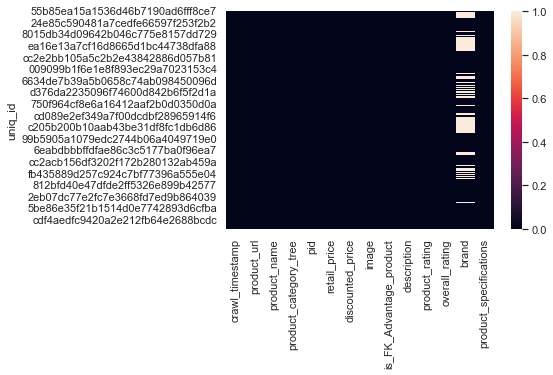

In [14]:
#Heatmap pour voir les colonnes manquantes
sns.heatmap(data.isna())

## Colonnes dupliquées

In [15]:
for col in data.columns :
    n = data.duplicated(subset=col).sum()
    print(f'col : {col} -> duplicated : {n}')

col : crawl_timestamp -> duplicated : 901
col : product_url -> duplicated : 0
col : product_name -> duplicated : 0
col : product_category_tree -> duplicated : 408
col : pid -> duplicated : 0
col : retail_price -> duplicated : 695
col : discounted_price -> duplicated : 625
col : image -> duplicated : 0
col : is_FK_Advantage_product -> duplicated : 1048
col : description -> duplicated : 0
col : product_rating -> duplicated : 1023
col : overall_rating -> duplicated : 1023
col : brand -> duplicated : 559
col : product_specifications -> duplicated : 65


## Data Inspection

In [16]:
#Stats des colonnes numériques
data.describe(include=np.number)

,retail_price,discounted_price
count,1049.00,1049.00
mean,2186.20,1584.53
std,7639.23,7475.10
min,35.00,35.00
25%,555.00,340.00
50%,999.00,600.00
75%,1999.00,1199.00
max,201000.00,201000.00


In [17]:
#Stats en incluant colonne varchar
data.describe(include=object)

,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049
unique,149,1050,1050,642,1050,1050,1050,27,27,490,984
top,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars""]",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""value""=>""Mug""}, {""key""=>""Mug Capacity"", ""value""=>""5...."
freq,150,1,1,56,1,1,1,889,889,11,22


# Product category analysis
Colonne intéressante : catégorie de produit + sous catégorie (Ex: Electroménager + cuisine + cuisson 
Analyser les catégories de produits et les sous catégories de produit

1er niveau de catégories : combien de catégries et nb produit par catégorie
Idem pour la 2e catégore : nb Catégries + répartition

In [18]:
data.shape

(1050, 14)

In [19]:
data.sample(2)

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
uniq_id,,,,,,,,,,,,,,
964648862f322b2cc153239af04b22ef,2016-01-07 05:50:25 +0000,http://www.flipkart.com/arb-toshiba-dynabook-ss-mx-395ls-compatible-black-6-cell-laptop-battery/...,ARB Toshiba Dynabook SS MX/395LS Compatible Black 6 Cell Laptop Battery,"[""Computers >> Laptop Accessories >> Batteries >> ARB Batteries""]",ACCDY6GVZYHGRRPP,3499.00,1599.00,964648862f322b2cc153239af04b22ef.jpg,False,Buy ARB Toshiba Dynabook SS MX/395LS Compatible Black 6 Cell Laptop Battery only for Rs. 1599 fr...,No rating available,No rating available,ARB,"{""product_specification""=>[{""key""=>""In The Box"", ""value""=>""Laptop Battery""}, {""key""=>""Brand"", ""v..."
17a73d7c4b02ada2bfeed1115fed08a4,2015-12-01 06:13:00 +0000,http://www.flipkart.com/envy-1000-force-combo-set/p/itme79cefgurn3bx?pid=CAGE79CEHJZX52XS,Envy-1000 Force Combo Set,"[""Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> Envy-1000 Combos""]",CAGE79CEHJZX52XS,360.00,329.00,17a73d7c4b02ada2bfeed1115fed08a4.jpg,False,Flipkart.com: Buy Envy-1000 Force Combo Set online only for Rs. 360 from Flipkart.com. Only Genu...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of Contents in Set"", ""value""=>""2""}, {""key""=>""Combo Se..."


Length
Calculer la longueur des documents category product : Nbre de caractères

In [20]:
data.product_category_tree.apply(lambda i : len(i))

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    112
7b72c92c2f6c40268628ec5f14c6d590    137
64d5d4a258243731dc7bbb1eef49ad74    136
d4684dcdc759dd9cdf41504698d737d8    135
6325b6870c54cd47be6ebfbffa620ec7    126
                                   ... 
958f54f4c46b53c8a0a9b8167d9140bc     71
fd6cbcc22efb6b761bd564c28928483c     69
5912e037d12774bb73a2048f35a00009     67
c3edc504d1b4f0ba6224fa53a43a7ad6     69
f2f027ad6a6df617c9f125173da71e44     67
Name: product_category_tree, Length: 1050, dtype: int64

In [21]:
## de manière graphique en appelant la méthode len de str
tmp = data.product_category_tree.str.len()

C:\Users\ADSL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='product_category_tree'>

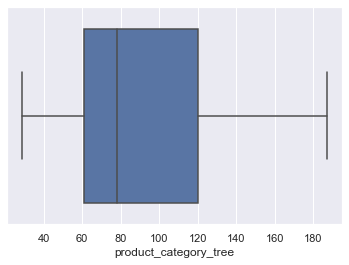

In [22]:
sns.boxplot(tmp)

La majorité des catégories fait entre 70 et 140 caractères avec une moyenne de 100 car.

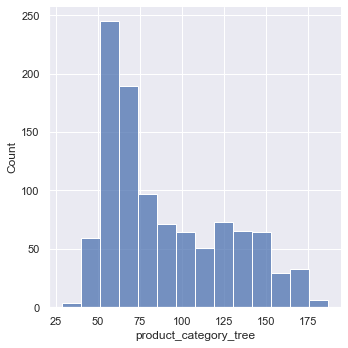

In [23]:
#Distribution nombre de catégories/longueur de texte
sns.displot(tmp)

Stockons le vecteur numérique dans 1 colonne len_cat

In [24]:
data['cat_prod_len_text'] = tmp

In [25]:
data.sort_values('cat_prod_len_text').head(5)

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_prod_len_text
uniq_id,,,,,,,,,,,,,,,
159b45e4dede207f28319bf1cacee3bc,2015-12-20 08:26:17 +0000,http://www.flipkart.com/msenterprises-floral-cushions-cover/p/itmedgm4rqmjswvg?pid=CPCEDGM4RPXJHBHG,MSenterprises Floral Cushions Cover,"[""Home Furnishing >> Living""]",CPCEDGM4RPXJHBHG,1299.00,580.00,159b45e4dede207f28319bf1cacee3bc.jpg,False,"MSenterprises Floral Cushions Cover (Pack of 5, 40 cm*40 cm, Brown)\r\n ...",No rating available,No rating available,MSenterprises,"{""product_specification""=>[{""key""=>""Closure"", ""value""=>""Zipper""}, {""key""=>""Brand"", ""value""=>""MSe...",29
e56ffc10078972b5f4e7302383db8d72,2015-12-20 08:26:17 +0000,http://www.flipkart.com/nikunj-abstract-cushions-cover/p/itmecsab9nyeehn4?pid=CPCECSABG58X5KHG,Nikunj Abstract Cushions Cover,"[""Home Furnishing >> Living""]",CPCECSABG58X5KHG,1199.00,999.00,e56ffc10078972b5f4e7302383db8d72.jpg,False,"Nikunj Abstract Cushions Cover (Pack of 5, 40 cm*40 cm, Grey)\r\n Price:...",No rating available,No rating available,Nikunj,"{""product_specification""=>[{""key""=>""Closure"", ""value""=>""Zipper""}, {""key""=>""Brand"", ""value""=>""Nik...",29
bcb8e456728013a90ba66ab3b1b783ad,2016-01-07 04:32:43 +0000,http://www.flipkart.com/hp-15-ac121tu-notebook-core-i3-5th-gen-4gb-1tb-win10-n8m17pa/p/itmeaz943...,HP 15-ac121tu (Notebook) (Core i3 (5th Gen)/ 4GB/ 1TB/ Win10) (N8M17PA),"[""Computers >> Laptops >> HP Laptops""]",COMEAZ94HWYQTZHZ,35390.00,35390.00,bcb8e456728013a90ba66ab3b1b783ad.jpg,True,Buy HP 15-ac121tu (Notebook) (Core i3 (5th Gen)/ 4GB/ 1TB/ Win10) (N8M17PA) Online For Rs.35390 ...,4.5,4.5,HP,"{""product_specification""=>[{""key""=>""Included Software"", ""value""=>""CyberLink YouCam, CyberLink Ph...",38
85aec4bf3185da7ebcc45003429cbfe2,2016-01-07 04:32:43 +0000,http://www.flipkart.com/hp-15-ac116tx-notebook-core-i3-5th-gen-4gb-1tb-win10-2gb-graph-n8m19pa/p...,HP 15-ac116TX (Notebook) (Core i3 (5th Gen)/ 4GB/ 1TB/ Win10/ 2GB Graph) (N8M19PA),"[""Computers >> Laptops >> HP Laptops""]",COMEAZ945RHFFGUS,38890.00,38890.00,85aec4bf3185da7ebcc45003429cbfe2.jpg,True,Buy HP 15-ac116TX (Notebook) (Core i3 (5th Gen)/ 4GB/ 1TB/ Win10/ 2GB Graph) (N8M19PA) Online Fo...,5,5,HP,"{""product_specification""=>[{""key""=>""Included Software"", ""value""=>""CyberLink YouCam, CyberLink Ph...",38
d395b2f3d13ff8897f403c6141e0e39a,2015-12-20 08:26:17 +0000,http://www.flipkart.com/amber-cotton-set-towels/p/itme3smgsspgkvbs?pid=BTWE3SMGZCGQMAZX,Amber Cotton Set of Towels,"[""Home Furnishing >> Bath Linen >> Towels""]",BTWE3SMGZCGQMAZX,523.00,239.00,d395b2f3d13ff8897f403c6141e0e39a.jpg,False,Buy Amber Cotton Set of Towels at Rs. 239 at Flipkart.com. Only Genuine Products. Free Shipping....,No rating available,No rating available,Amber,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""F...",43


In [26]:
data.sort_values('cat_prod_len_text').tail(5)

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_prod_len_text
uniq_id,,,,,,,,,,,,,,,
2414e4b7e5948263b8dbb4843557be4d,2016-03-07 19:42:22 +0000,http://www.flipkart.com/smart-wall-guru-large-adhesive-sticker/p/itmegkhujkkrxy22?pid=STIEGKHUWG...,Smart Wall Guru Large Adhesive Sticker Sticker,"[""Home Decor & Festive Needs >> Wall Decor & Clocks >> Wall Decals & Stickers >> Smart Wall Guru...",STIEGKHUWG8GTKFB,1599.00,499.00,2414e4b7e5948263b8dbb4843557be4d.jpg,False,Key Features of Smart Wall Guru Large Adhesive Sticker Sticker Make For Smart Bedroom Study room...,No rating available,No rating available,Smart Wall Guru,"{""product_specification""=>[{""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 1""},...",176
61c0139f3d5c97f1615797dbf046cc0c,2016-05-16 22:42:47 +0000,http://www.flipkart.com/smart-wall-guru-medium-adhesive-sticker/p/itmegpnxaduhzwgx?pid=STIEGPNXU...,Smart Wall Guru Medium Adhesive Sticker,"[""Home Decor & Festive Needs >> Wall Decor & Clocks >> Wall Decals & Stickers >> Smart Wall Guru...",STIEGPNXUZ7MJHNF,1199.00,299.00,61c0139f3d5c97f1615797dbf046cc0c.jpg,False,Key Features of Smart Wall Guru Medium Adhesive Sticker We Showcase A Variety Of Wall Decal Cate...,No rating available,No rating available,Smart Wall Guru,"{""product_specification""=>[{""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 1""},...",176
29def171d7e31d48571a52f0fb3e6b07,2016-03-02 19:09:22 +0000,http://www.flipkart.com/ech-oly-ceramic-inside-fitting-hookah-mouth-tip/p/itmefw3sxxy6xmuh?pid=H...,Ech oly Ceramic Inside Fitting Hookah Mouth Tip,"[""Home Decor & Festive Needs >> Table Decor & Handicrafts >> Table Decor >> Hookah Mouth Tips >>...",HMTEFW3SGGF9HYPT,1799.00,699.00,29def171d7e31d48571a52f0fb3e6b07.jpg,False,Ech oly Ceramic Inside Fitting Hookah Mouth Tip (Black) Price: Rs. 699 Durable and can be used r...,No rating available,No rating available,Ech oly,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Ech oly""}, {""key""=>""Model Number"", ""value""...",179
fa2e5f01bbb642c49e4b2e19d2b39dcf,2016-05-19 02:12:59 +0000,http://www.flipkart.com/lottie-london-make-me-blush/p/itmegtpn3epjdghr?pid=BAREGTPNZNHZHA8Z,LOTTIE LONDON MAKE ME BLUSH,"[""Beauty and Personal Care >> Beauty Accessories >> Makeup Accessories >> Brushes and Applicator...",BAREGTPNZNHZHA8Z,850.00,765.00,fa2e5f01bbb642c49e4b2e19d2b39dcf.jpg,False,LOTTIE LONDON MAKE ME BLUSH (Pack of 1) Price: Rs. 765 Add a perfectly flushed pop of colour to ...,No rating available,No rating available,LOTTIE LONDON,"{""product_specification""=>[{""key""=>""Brush Type"", ""value""=>""BLUSH BRUSH""}, {""key""=>""Number of Pie...",183
7821fb1cbf8d3bb294c3c20527119f15,2016-03-03 06:06:42 +0000,http://www.flipkart.com/surgical-e-sstudio-s0004-gown-pant-hospital-scrub/p/itmeg6yur3fwfbfs?pid...,"Surgical e Sstudio S0004 Gown, Pant Hospital Scrub","[""Beauty and Personal Care >> Health Care >> Medical Equipment & Accessories >> Surgical e Sstud...",HTSEG6YUAFSNFG6M,2500.00,1650.00,7821fb1cbf8d3bb294c3c20527119f15.jpg,False,"Key Features of Surgical e Sstudio S0004 Gown, Pant Hospital Scrub Washable High Quality Polyest...",No rating available,No rating available,Surgical e Sstudio,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Surgical e Sstudio""}, {""key""=>""Brand Color...",187


In [27]:
# Determining the maximum tree depth of categories

ser_depth = data['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()
max_depth

6

In [28]:
# Suppression de la colonne cat_prod_len_text
data.drop(columns='cat_prod_len_text', inplace=True)

In [29]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = data['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=data.index)

In [30]:
# printing number of categories in each level and a sample
display(df_cat_level.nunique(), df_cat_level.sample(3))

cat_level_0      7
cat_level_1     62
cat_level_2    243
cat_level_3    460
cat_level_4    596
cat_level_5    633
dtype: int64

,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5
uniq_id,,,,,,
a371cfcae8c6ec3b82ae37a83a8ae9b9,Home Furnishing,Home Furnishing/Bed Linen,"Home Furnishing/Bed Linen/Blankets, Quilts & Dohars","Home Furnishing/Bed Linen/Blankets, Quilts & Dohars/","Home Furnishing/Bed Linen/Blankets, Quilts & Dohars//","Home Furnishing/Bed Linen/Blankets, Quilts & Dohars///"
a43fbae655e5d13215b9dd65339fa9d4,Computers,Computers/Network Components,Computers/Network Components/Routers,Computers/Network Components/Routers/Huawei Routers,Computers/Network Components/Routers/Huawei Routers/,Computers/Network Components/Routers/Huawei Routers//
735820e1614052fde55659da9dc10ccc,Kitchen & Dining,Kitchen & Dining/Bar & Glassware,Kitchen & Dining/Bar & Glassware/Bar Accessories,Kitchen & Dining/Bar & Glassware/Bar Accessories/Bottle Openers,Kitchen & Dining/Bar & Glassware/Bar Accessories/Bottle Openers/arnavs Bottle Openers,Kitchen & Dining/Bar & Glassware/Bar Accessories/Bottle Openers/arnavs Bottle Openers/arnavs Mul...


## Items Number in each category

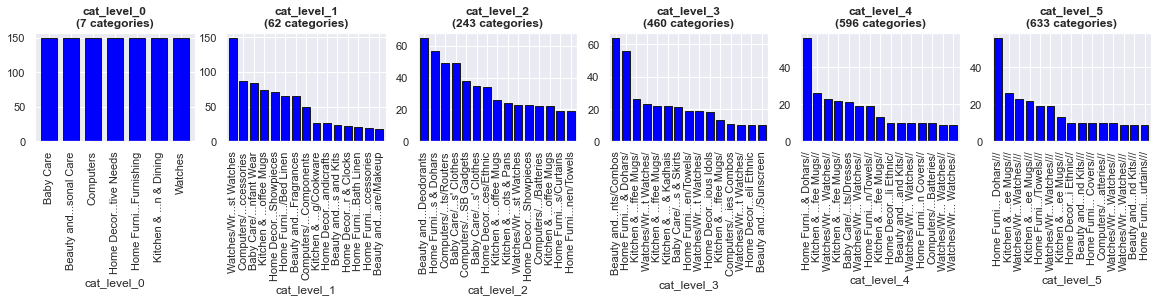

In [31]:
shorten_label = 10
n_first = 15
fig = plt.figure(figsize=(20,2))
for i, col in enumerate(df_cat_level.columns,1):
    # plot the graphs
    ax = fig.add_subplot(1,len(df_cat_level.columns), i)
    ser = df_cat_level.groupby(col).size().sort_values(ascending=False)
    ser[0:n_first].plot.bar(width=0.75, color='blue', ec='k', ax=ax)
    # shorten the labels
    thr = int(shorten_label)
    lab_x = [item.get_text() for item in ax.get_xticklabels()]
    short_lab_x = [s[:thr]+'...'+s[-thr:] if len(s)>thr else s for s in lab_x]
    ax.axes.set_xticklabels(short_lab_x)
    # set title
    ax.set_title(col+f'\n({ser.shape[0]} categories)', fontweight='bold')

In [32]:
# Category level 0
df_cat_level.cat_level_0.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

Level_0 has 7 catagries and 150 products by categroy. He is balanced. So lets get only level_0 and rename this 7 categories

In [33]:
df_cat_level['category'] = \
df_cat_level['cat_level_0'].replace ({'Home Furnishing' : 'Furnishing',
                                      'Baby Care' : 'Baby',
                                      'Home Decor & Festive Needs' : 'Home',
                                      'Kitchen & Dining' : 'Kitchen',
                                      'Beauty and Personal Care' : 'Beauty'
                                     })

In [34]:
df_cat_level.sample(3)

,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5,category
uniq_id,,,,,,,
c7d81193e868b50355412ced7a67f8f3,Watches,Watches/Wrist Watches,Watches/Wrist Watches/Maxima Wrist Watches,Watches/Wrist Watches/Maxima Wrist Watches/,Watches/Wrist Watches/Maxima Wrist Watches//,Watches/Wrist Watches/Maxima Wrist Watches///,Watches
9438a0874e0486f46f3669cac6c2ac90,Computers,Computers/Network Components,Computers/Network Components/Routers,Computers/Network Components/Routers/Edimax Routers,Computers/Network Components/Routers/Edimax Routers/,Computers/Network Components/Routers/Edimax Routers//,Computers
fc93a41f31c4e997fbfcc5bd0a63ee65,Watches,Watches/Wrist Watches,Watches/Wrist Watches/Perucci Wrist Watches,Watches/Wrist Watches/Perucci Wrist Watches/,Watches/Wrist Watches/Perucci Wrist Watches//,Watches/Wrist Watches/Perucci Wrist Watches///,Watches


In [35]:
df_cat_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 55b85ea15a1536d46b7190ad6fff8ce7 to f2f027ad6a6df617c9f125173da71e44
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cat_level_0  1050 non-null   object
 1   cat_level_1  1050 non-null   object
 2   cat_level_2  1050 non-null   object
 3   cat_level_3  1050 non-null   object
 4   cat_level_4  1050 non-null   object
 5   cat_level_5  1050 non-null   object
 6   category     1050 non-null   object
dtypes: object(7)
memory usage: 97.9+ KB


In [36]:
data.sample(1)

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
uniq_id,,,,,,,,,,,,,,
5cd3d274d71e1e0d6bf075421461b2d5,2016-01-01 19:37:22 +0000,http://www.flipkart.com/sapatos-geometric-single-duvet-purple-pink/p/itmeejgjgfvheujz?pid=BLAEEJ...,Sapatos Geometric Single Duvet Purple & Pink,"[""Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars""]",BLAEEJGJ6T2NHJRK,2999.00,1499.00,5cd3d274d71e1e0d6bf075421461b2d5.jpg,False,Sapatos Geometric Single Duvet Purple & Pink (Single duvet)\r\n Price: R...,No rating available,No rating available,Sapatos,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""No""}, {""key""=>""Brand"", ""value""=..."


## Simplify the dataset
Have only category, product name and product description

In [37]:
df = pd.concat([df_cat_level['category'], data[['product_name', 'description']]], axis=1)

In [38]:
df.sample(5)

,category,product_name,description
uniq_id,,,
8e94fbcd81112a21860355b3b11cf52d,Beauty,"Denver Sport,Hamilton Combo Set","Flipkart.com: Buy Denver Sport,Hamilton Combo Set online only for Rs. 350 from Flipkart.com. Onl..."
378d7dbdb97ecc62c9ad52cb6df23a86,Kitchen,Checkered Chef Steel All-Purpose Scissor,"Checkered Chef Steel All-Purpose Scissor (Red, Black, Silver, Pack of 1) Price: Rs. 1,921 YOUR S..."
0bff0eda7a6677dc1acb0477a1f7a121,Baby,"Shaun Solid Baby Boy's Grey, Dark Blue Track Pants","Specifications of Shaun Solid Baby Boy's Grey, Dark Blue Track Pants Track Pant Details Number o..."
a898bd6978f9f2c6aa940b9fa3352c27,Beauty,Archies VJ-552 Combo Set,Flipkart.com: Buy Archies VJ-552 Combo Set online only for Rs. 399 from Flipkart.com. Only Genui...
374e63028d691c380bc43b0dc60e460d,Home,@home Glass Vase,"Specifications of @home Glass Vase (18 inch, Grey) General Brand @home Suitable For Table Model ..."


## Look to the particular items

In [39]:
df.loc['4a1b23dacd7d2a9ec7414f7159f25a48'].product_name

'Mars Queen Eye Liner, Lip Gloss, EyeLiner'

In [40]:
df.loc['4a1b23dacd7d2a9ec7414f7159f25a48'].description

'Mars Queen Eye Liner, Lip Gloss, EyeLiner (Set of 3) Price: Rs. 299 1 Queen Eye Liner, 1 Lip Gloss, 1 EyeLiner,Specifications of Mars Queen Eye Liner, Lip Gloss, EyeLiner (Set of 3) Combo Set Details Number of Contents in Combo Set 3 Combo Set Contents 1 Queen Eye Liner, 1 Lip Gloss, 1 EyeLiner Ideal For Women Organic No General Traits Professional Care Yes Gift Pack Yes'

In [41]:
df.loc['d21409978f5e404b53f89e444f7893fe'].product_name

'SF by Sonata 7991PP02 Ocean Digital Watch  - For Men'

In [42]:
df.loc['d21409978f5e404b53f89e444f7893fe'].description

'SF by Sonata 7991PP02 Ocean Digital Watch  - For Men - Buy SF by Sonata 7991PP02 Ocean Digital Watch  - For Men  7991PP02 Online at Rs.999 in India Only at Flipkart.com. Water Resistant, Round Dial, Black Strap - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

# Explore corpus and documents :

### Nan and duplicated

In [43]:
df.isna().sum()

category        0
product_name    0
description     0
dtype: int64

In [44]:
df.duplicated().sum()

0

In [45]:
df.duplicated('product_name').sum()

0

In [46]:
df.duplicated('description').sum()

0

Longueur des documents

In [47]:
df.description.apply(lambda i : len(i))

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    1420
7b72c92c2f6c40268628ec5f14c6d590     444
64d5d4a258243731dc7bbb1eef49ad74    1258
d4684dcdc759dd9cdf41504698d737d8     858
6325b6870c54cd47be6ebfbffa620ec7    1197
                                    ... 
958f54f4c46b53c8a0a9b8167d9140bc    2432
fd6cbcc22efb6b761bd564c28928483c    1660
5912e037d12774bb73a2048f35a00009     262
c3edc504d1b4f0ba6224fa53a43a7ad6     210
f2f027ad6a6df617c9f125173da71e44     187
Name: description, Length: 1050, dtype: int64

la taille de description est très variable

In [48]:
df.product_name.apply(lambda i : len(i))

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    58
7b72c92c2f6c40268628ec5f14c6d590    26
64d5d4a258243731dc7bbb1eef49ad74    35
d4684dcdc759dd9cdf41504698d737d8    63
6325b6870c54cd47be6ebfbffa620ec7    53
                                    ..
958f54f4c46b53c8a0a9b8167d9140bc    46
fd6cbcc22efb6b761bd564c28928483c    38
5912e037d12774bb73a2048f35a00009    65
c3edc504d1b4f0ba6224fa53a43a7ad6    39
f2f027ad6a6df617c9f125173da71e44    28
Name: product_name, Length: 1050, dtype: int64

In [49]:
## de manière graphique en appelant la méthode len de str
df_sample = data.description.str.len()

C:\Users\ADSL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='description'>

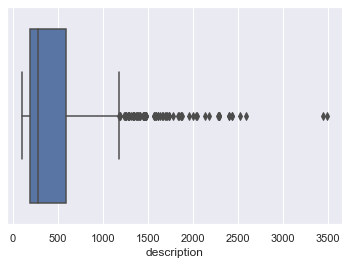

In [50]:
sns.boxplot(df_sample)

La majorité des descriptions fait entre 200 et 600 caractères avec une moyenne de 250 car.
On qq ouliers avec une taille élevée

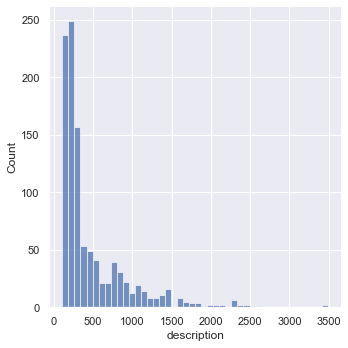

In [51]:
#Distribution nombre de description/longueur de texte
sns.displot(df_sample)

In [52]:
df_sample = df.sample(5)
df_sample

,category,product_name,description
uniq_id,,,
4f8f64f93f789af51bb07296639acbd2,Beauty,Oxyglow Saffron with vitamin-E Gold Massage Cream & Almond Under Eye Repair Care,Buy Oxyglow Saffron with vitamin-E Gold Massage Cream & Almond Under Eye Repair Care for Rs.579 ...
968a2b3be84193e3f755c2fe71033a2c,Home,Sovam International Krishna With Cow Idol Showpiece - 6 cm,"Sovam International Krishna With Cow Idol Showpiece - 6 cm (Brass, White)\r\n ..."
621a88993a7033df3440ec816c2e386f,Computers,"Shopfloor.XYZ Vacuum Cleaner for Computers, Laptops, Mobiles","Shopfloor.XYZ Vacuum Cleaner for Computers, Laptops, Mobiles (SF-VC_011) Price: Rs. 269 Requires..."
894904e26516d491bf1c7711fe800e78,Watches,"Only Kidz 20600 Digital Watch - For Boys, Girls","Only Kidz 20600 Digital Watch - For Boys, Girls - Buy Only Kidz 20600 Digital Watch - For Boys..."
b52073e7ed9c00c4108cae4eb0c49c1a,Watches,"Vizion 8502-7PURPLE Sports Series Digital Watch - For Boys, Girls","Vizion 8502-7PURPLE Sports Series Digital Watch - For Boys, Girls\r\n P..."


In [53]:
# Loguenur du nom du produit
df.product_name.apply(lambda i : len(i))

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    58
7b72c92c2f6c40268628ec5f14c6d590    26
64d5d4a258243731dc7bbb1eef49ad74    35
d4684dcdc759dd9cdf41504698d737d8    63
6325b6870c54cd47be6ebfbffa620ec7    53
                                    ..
958f54f4c46b53c8a0a9b8167d9140bc    46
fd6cbcc22efb6b761bd564c28928483c    38
5912e037d12774bb73a2048f35a00009    65
c3edc504d1b4f0ba6224fa53a43a7ad6    39
f2f027ad6a6df617c9f125173da71e44    28
Name: product_name, Length: 1050, dtype: int64

### Concaténer le nom du produit avec la description 
Ne garder que la description du produit et sa categorie

In [54]:
#Renommer la catégorie produit
df['description'] =df['product_name'] + ' ' + df['description']

In [55]:
# Suppression de la colonne product_name
df.drop(columns='product_name', inplace=True)

In [56]:
#df.category.unique()

In [57]:
#df[df['category'] =='Watches']
#order_items[order_items['order_id'] == '9c4f3693a36ba481e0d9da739679660c']

In [58]:
#imprimer la catégorie du produit, le nom du produit et sa description avec une meilleure présentation
for idx, ser in df_sample.iterrows() :
    txt_1 = f"category_product : {ser['category']}\n" #Target + saut dde lignes
    print(txt_1 + ser['description']+ "..." + '\n\n\n') #2 retours chariots
   ## print(txt_1 + ser['description']+ "..." + '\n\n') #2 retours chariots

category_product : Beauty
Buy Oxyglow Saffron with vitamin-E Gold Massage Cream & Almond Under Eye Repair Care for Rs.579 online. Oxyglow Saffron with vitamin-E Gold Massage Cream & Almond Under Eye Repair Care at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....



category_product : Home
Sovam International Krishna With Cow Idol Showpiece  -  6 cm (Brass, White)
                         Price: Rs. 1,240
				
			this handcrafted antique idol of Lord Krishna with Cow on metal durable stand is made of pure white metal. The idol is silver polished to give it alluring antique look. It is also an ideal gift for your friends and relatives. The gift piece has been prepared by the creative artisans
this handcrafted antique idol of Lord Krishna with Cow on metal durable stand is made of pure white metal. The idol is silver polished to give it alluring antique look. It is also an ideal gift for your friends and relatives. The gift piece h

In [59]:
#Imprimer 10 documents au hasard d'un sous dataframe
def print_sample(sub_df, n_sample=10):
    """ print out n_samples documents from a corpus """
    samp = sub_df.sample(n_sample)
    for idx, ser in samp.iterrows() :
        txt_1 = f"category : {ser['category']}\n" #Target + RC
        print(txt_1 + ser['description']+ "..." + '\n\n') #2 RC

In [60]:
print_sample(df)

category : Home
Nihar Pirangi Bomber Showpiece  -  10 cm Buy Nihar Pirangi Bomber Showpiece  -  10 cm for Rs.194 online. Nihar Pirangi Bomber Showpiece  -  10 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....


category : Baby
Funcart Frolic Birthday  - Food Grade Plastic Flipkart.com is offering Small Funcart Frolic Birthday  - Food Grade Plastic for only for Rs 154 | Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


category : Furnishing
Rama Floral Single Quilts & Comforters Pink-Red Buy Rama Floral Single Quilts & Comforters Pink-Red at Rs. 749 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


category : Kitchen
Deep kitchen press Steel Grater and Slicer Specifications of Deep kitchen press Steel Grater and Slicer (Steel, Pack of 16) General Brand Deep Model Number 112 Type Grater and Slicer Material Steel Model Name kitchen press Slicer Type NA Color Steel In the box

 # Text Processing
 ## text cleaning : Tokenizer, stop words, baw, etc..
 Tokeniser = réduire un ensembe de documents en briques élémentaires

In [61]:
import spacy
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()
doc = nlp("This is a sentence.")
print([(w.text, w.pos_) for w in doc])

[('This', 'PRON'), ('is', 'AUX'), ('a', 'DET'), ('sentence', 'NOUN'), ('.', 'PUNCT')]


In [62]:
# Stemmer or lemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy

stemmer = EnglishStemmer()
lemmatizer = spacy.load("en_core_web_sm", disable=["tok2vec", "parser", "ner", "attrbute_ruler"])

In [63]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw



#--------------------------------------
# Utliser le lemmatiser et stemmer de spacy plus performant que nltk
# Lemmatizer (base d'un mot)

def lemma_fct(list_words) :
    lem_doc = lemmatizer(' '.join(list_words))
    lem_w = [token.lemma_ for token in lem_doc]
    return lem_w



#from nltk.stem import WordNetLemmatizer

#def lemma_fct(list_words) :
#    lemmatizer = WordNetLemmatizer()
#    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
#    return lem_w
   
#------------------------------------

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text



In [64]:
#Préparation de chq type de bag of words et ajout dans les colonnes du dataset
df['description_bow'] =     df['description'].apply(lambda x : transform_bow_fct(x))
df['description_bow_lem'] = df['description'].apply(lambda x : transform_bow_lem_fct(x))##Pour lematiser
df['description_dl'] =      df['description'].apply(lambda x : transform_dl_fct(x)) ##Pour le DeepLearning
df.shape

(1050, 5)

In [65]:
#Sauvegardre le dataframe  nettoyé
df.to_csv(path + '/cleaned/flipkart_com_cleaned.csv', index=True)# pour éviter d'avoir une colonne unamed=0, spécifier index=False

In [66]:
df.sample(5)

,category,description,description_bow,description_bow_lem,description_dl
uniq_id,,,,,
8ec6ee9814a27423e66c3c9ea26f77aa,Furnishing,Scalabedding Cotton Striped King sized Double Bedsheet Buy Scalabedding Cotton Striped King size...,scalabedding cotton striped king sized double bedsheet buy scalabedding cotton striped king size...,scalabedde cotton stripe king size double bedsheet buy scalabedde cotton stripe king size double...,scalabedding cotton striped king sized double bedsheet buy scalabedding cotton striped king size...
8876d7569efdaff5a21b33a1ab44a13d,Baby,MKB Baby Girl's Shirt Dress Key Features of MKB Baby Girl's Shirt Dress Material: Velvet & Net L...,mkb baby girl shirt dress key features mkb baby girl shirt dress material velvet net length inch...,mkb baby girl shirt dress key feature mkb baby girl shirt dress material velvet net length inch ...,mkb baby girl 's shirt dress key features of mkb baby girl 's shirt dress material : velvet & ne...
4a1b23dacd7d2a9ec7414f7159f25a48,Beauty,"Mars Queen Eye Liner, Lip Gloss, EyeLiner Mars Queen Eye Liner, Lip Gloss, EyeLiner (Set of 3) P...",mars queen eye liner lip gloss eyeliner mars queen eye liner lip gloss eyeliner set price 299 qu...,mars queen eye liner lip gloss eyeliner mars queen eye liner lip gloss eyeliner set price 299 qu...,"mars queen eye liner , lip gloss , eyeliner mars queen eye liner , lip gloss , eyeliner ( set of..."
908cc351957d02f72f60916006c531ba,Home,Rajo Raja Mahavastu Buddha Artpiece Showpiece - 20.5 cm Buy Rajo Raja Mahavastu Buddha Artpiec...,rajo raja mahavastu buddha artpiece showpiece 20.5 buy rajo raja mahavastu buddha artpiece showp...,rajo raja mahavastu buddha artpiece showpiece 20.5 buy rajo raja mahavastu buddha artpiece showp...,rajo raja mahavastu buddha artpiece showpiece 20.5 cm buy rajo raja mahavastu buddha artpiece sh...
d21409978f5e404b53f89e444f7893fe,Watches,SF by Sonata 7991PP02 Ocean Digital Watch - For Men SF by Sonata 7991PP02 Ocean Digital Watch ...,sonata 7991pp02 ocean digital watch for men sonata 7991pp02 ocean digital watch for men buy sona...,sonata 7991pp02 ocean digital watch for man sonata 7991pp02 ocean digital watch for man buy sona...,sf by sonata 7991pp02 ocean digital watch for men sf by sonata 7991pp02 ocean digital watch for ...


In [67]:
df['length_bow'] = df['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df['length_bow'].max())
df['length_dl'] = df['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df['length_dl'].max())
df['length_lem'] = df['description_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length lem : ", df['length_lem'].max())

max length bow :  384
max length dl :  637
max length lem :  384


In [68]:
df.sample(5)

,category,description,description_bow,description_bow_lem,description_dl,length_bow,length_dl,length_lem
uniq_id,,,,,,,,
c75d6d827876b0d0127acb59e5a251ee,Computers,TRENDnet TEW-752DRU Buy TRENDnet TEW-752DRU only for Rs. 5199 from Flipkart.com. Only Genuine Pr...,trendnet tew 752dru buy trendnet tew 752dru 5199 flipkart.com only genuine products day replacem...,trendnet tew 752dru buy trendnet tew 752dru 5199 flipkart.com only genuine product day replaceme...,trendnet tew 752dru buy trendnet tew 752dru only for rs . 5199 from flipkart.com . only genuine ...,19,31,19
9c8fdf6c9c631d0892e9a6f55a4a2fd2,Beauty,"NYX Set Of 2 Soft Matte Lip Cream 06,22 NYX Set Of 2 Soft Matte Lip Cream 06,22 (Multi color) Pr...","nyx set soft matte lip cream 06,22 nyx set soft matte lip cream 06,22 multi color price 1,600 ny...","nyx set soft matte lip cream 06,22 nyx set soft matte lip cream 06,22 multi color price 1,600 ny...","nyx set of 2 soft matte lip cream 06,22 nyx set of 2 soft matte lip cream 06,22 ( multi color ) ...",86,123,86
c5590e238d44b370337624f5987fb9b8,Kitchen,Rockmantra Abstrcts 8 Ceramic Mug Rockmantra Abstrcts 8 Ceramic Mug (5.5 l)\r\n ...,rockmantra abstrcts ceramic mug rockmantra abstrcts ceramic mug 5.5 price 199 give thrilling yet...,rockmantra abstrct ceramic mug rockmantra abstrct ceramic mug 5.5 price 199 give thrilling yet f...,rockmantra abstrcts 8 ceramic mug rockmantra abstrcts 8 ceramic mug ( 5.5 l ) price : rs . 199 g...,81,145,81
e0e261a0d4fd2ffdcbcad324e91a0dd4,Furnishing,Ally The Creations Printed Cushions Cover Key Features of Ally The Creations Printed Cushions Co...,ally the creations printed cushions cover key features ally the creations printed cushions cover...,ally the creation print cushion cover key feature ally the creation print cushion cover style cu...,ally the creations printed cushions cover key features of ally the creations printed cushions co...,126,198,126
a7bd63ef1d3b345d7f9a162865bb7c0d,Watches,"Flippd FD040149 Casual Analog Watch - For Women, Girls Flippd FD040149 Casual Analog Watch - F...",flippd fd040149 casual analog watch for women girls flippd fd040149 casual analog watch for wome...,flippd fd040149 casual analog watch for woman girl flippd fd040149 casual analog watch for woman...,"flippd fd040149 casual analog watch for women , girls flippd fd040149 casual analog watch for wo...",43,57,43


In [69]:
df.loc['4a1b23dacd7d2a9ec7414f7159f25a48'].description_bow

'mars queen eye liner lip gloss eyeliner mars queen eye liner lip gloss eyeliner set price 299 queen eye liner lip gloss eyeliner specifications mars queen eye liner lip gloss eyeliner set combo set details number contents combo set combo set contents queen eye liner lip gloss eyeliner ideal for women organic general traits professional care yes gift pack yes'

In [107]:
df.loc['4a1b23dacd7d2a9ec7414f7159f25a48'].description_bow_lem

'mars queen eye liner lip gloss eyeliner mars queen eye liner lip gloss eyeliner set price 299 queen eye liner lip gloss eyeliner specification mars queen eye liner lip gloss eyeliner set combo set detail number content combo set combo set content queen eye liner lip gloss eyeliner ideal for woman organic general trait professional care yes gift pack yes'

In [70]:
df.loc['4a1b23dacd7d2a9ec7414f7159f25a48'].description_dl

'mars queen eye liner , lip gloss , eyeliner mars queen eye liner , lip gloss , eyeliner ( set of 3 ) price : rs . 299 1 queen eye liner , 1 lip gloss , 1 eyeliner , specifications of mars queen eye liner , lip gloss , eyeliner ( set of 3 ) combo set details number of contents in combo set 3 combo set contents 1 queen eye liner , 1 lip gloss , 1 eyeliner ideal for women organic no general traits professional care yes gift pack yes'

In [71]:
df.loc['d21409978f5e404b53f89e444f7893fe'].description_bow

'sonata 7991pp02 ocean digital watch for men sonata 7991pp02 ocean digital watch for men buy sonata 7991pp02 ocean digital watch for men 7991pp02 online rs.999 india only flipkart.com water resistant round dial black strap great discounts only genuine products day replacement guarantee free shipping cash delivery'

In [72]:
df.loc['d21409978f5e404b53f89e444f7893fe'].description_dl

'sf by sonata 7991pp02 ocean digital watch for men sf by sonata 7991pp02 ocean digital watch for men buy sf by sonata 7991pp02 ocean digital watch for men 7991pp02 online at rs.999 in india only at flipkart.com . water resistant , round dial , black strap great discounts , only genuine products , 30 day replacement guarantee , free shipping . cash on delivery !'

In [73]:
#Supprimer les colonnes inutiles à ce stade
#Ne pas supprimer le txte brut de la colonne desription. Gardons le pour les autres modèles BERT, spacy etc..
cols = ['length_bow', 'length_dl', 'length_lem']#, 'description']
df.drop(columns=cols, inplace=True)

In [74]:
df.sample(2)

,category,description,description_bow,description_bow_lem,description_dl
uniq_id,,,,,
5db6bd89da44841c1a5b686e67137704,Watches,Sonata 1141YM22 Analog Watch - For Men Sonata 1141YM22 Analog Watch - For Men - Buy Sonata 114...,sonata 1141ym22 analog watch for men sonata 1141ym22 analog watch for men buy sonata 1141ym22 an...,sonata 1141ym22 analog watch for man sonata 1141ym22 analog watch for man buy sonata 1141ym22 an...,sonata 1141ym22 analog watch for men sonata 1141ym22 analog watch for men buy sonata 1141ym22 an...
8507eb0ef32c1c0db700f20aad6d9bcd,Kitchen,Rockmantra Sonakshi Sinha Beautiful Look Ceramic Mug Rockmantra Sonakshi Sinha Beautiful Look Ce...,rockmantra sonakshi sinha beautiful look ceramic mug rockmantra sonakshi sinha beautiful look ce...,rockmantra sonakshi sinha beautiful look ceramic mug rockmantra sonakshi sinha beautiful look ce...,rockmantra sonakshi sinha beautiful look ceramic mug rockmantra sonakshi sinha beautiful look ce...


In [75]:
#Pourcentage des produits par catégorie
df.category.value_counts(normalize=True)

Furnishing   0.14
Baby         0.14
Watches      0.14
Home         0.14
Kitchen      0.14
Beauty       0.14
Computers    0.14
Name: category, dtype: float64

taille des colonnes text

## Work in a specfic document

Fonction qui indique le nb de tokens et celui de tokens uniques

In [76]:
#select a random document
doc = df.description_bow.sample(1)
doc = doc.values[0]
doc

'rama floral single quilts comforters pink red buy rama floral single quilts comforters pink red 749 flipkart.com only genuine products free shipping cash delivery'

In [77]:
#tokenize
tokens = word_tokenize(doc)
tokens

['rama',
 'floral',
 'single',
 'quilts',
 'comforters',
 'pink',
 'red',
 'buy',
 'rama',
 'floral',
 'single',
 'quilts',
 'comforters',
 'pink',
 'red',
 '749',
 'flipkart.com',
 'only',
 'genuine',
 'products',
 'free',
 'shipping',
 'cash',
 'delivery']

In [78]:
#Longeur du documents en nombre de tokens
len(tokens)

24

In [79]:
#tokens uniques
len(set(tokens))

17

In [80]:
#Fonction qui indique le nb de tokens et celui de tokens uniques
def display_tokens_info(tokens) :
    """display info about corpus """
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30]) #print les 30 premiers tokens de notre liste

In [81]:
display_tokens_info(tokens)

nb tokens 24, nb tokens uniques 17
['rama', 'floral', 'single', 'quilts', 'comforters', 'pink', 'red', 'buy', 'rama', 'floral', 'single', 'quilts', 'comforters', 'pink', 'red', '749', 'flipkart.com', 'only', 'genuine', 'products', 'free', 'shipping', 'cash', 'delivery']


## Fonctions communes

In [82]:
# Les catégories des produits
l_cat = list(set(df['category']))
print("catégories : ", l_cat)
#transforme les catégories en format numérique
y_cat_num = [(1-l_cat.index(df.iloc[i]['category'])) for i in range(len(df))]

catégories :  ['Computers', 'Beauty', 'Watches', 'Home', 'Kitchen', 'Baby', 'Furnishing']


In [83]:
len(y_cat_num)

1050

In [84]:
len(l_cat)

7

In [85]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne en utlisant le Kmeans
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)


# Working on the entire corpus

## Build raw corpus
texte brut

In [86]:
df.sample(3)

,category,description,description_bow,description_bow_lem,description_dl
uniq_id,,,,,
c36ea960a14f164ee0f39ad6beb3796a,Watches,Sonata 77036SM02J Watch Sonata 77036SM02J Watch - Buy Sonata 77036SM02J Watch 77036SM02J Online...,sonata 77036sm02j watch sonata 77036sm02j watch buy sonata 77036sm02j watch 77036sm02j online rs...,sonata 77036sm02j watch sonata 77036sm02j watch buy sonata 77036sm02j watch 77036sm02j online rs...,sonata 77036sm02j watch sonata 77036sm02j watch buy sonata 77036sm02j watch 77036sm02j online at...
d43d9bb261aaaf818c81a645e727b2d3,Computers,TRENDnet THA-101 N300 Router Buy TRENDnet THA-101 N300 Router only for Rs. 4989 from Flipkart.co...,trendnet tha 101 n300 router buy trendnet tha 101 n300 router 4989 flipkart.com only genuine pro...,trendnet tha 101 n300 router buy trendnet tha 101 n300 router 4989 flipkart.com only genuine pro...,trendnet tha 101 n300 router buy trendnet tha 101 n300 router only for rs . 4989 from flipkart.c...
64a9d0488652194fd8e879d5e6dc8015,Watches,"palito PLO 149 Analog Watch - For Girls, Women Specifications of palito PLO 149 Analog Watch -...",palito plo 149 analog watch for girls women specifications palito plo 149 analog watch for girls...,palito plo 149 analog watch for girl woman specification palito plo 149 analog watch for girl wo...,"palito plo 149 analog watch for girls , women specifications of palito plo 149 analog watch for ..."


In [87]:
corpus = df.description_bow.values

In [88]:
#corpus_desc = ' '.join(df['description_bow'].values)

In [89]:
#corpus_desc

In [90]:
#Taille du corpus en nb de lignes
len(set(corpus))

1048

In [91]:
display_tokens_info(corpus)

nb tokens 1050, nb tokens uniques 1048
['elegance polyester multicolor abstract eyelet door curtain key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interiors.this curtain made 100 high quality polyester fabric.it features eyelet style stitch metal ring.it makes room environment romantic loving.this curtain ant wrinkle anti shrinkage elegant apparance.give home bright modernistic appeal designs the surreal attention sure steal hearts these contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight. specifications elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand el

In [92]:
df.loc['762b6b22cccf91935e92446efe298fe3', 'description_bow']

'612 league baby boy checkered casual shirt specifications 612 league baby boy checkered casual shirt general details pattern checkered occasion casual ideal for baby boy shirt details sleeve half sleeve number contents sales package pack brand fit regular fabric 100 cotton fit regular additional details style code bls00s380001b fabric care enzyme wash'

In [93]:
len(set(corpus))

1048

In [94]:
corpus

array(['elegance polyester multicolor abstract eyelet door curtain key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interiors.this curtain made 100 high quality polyester fabric.it features eyelet style stitch metal ring.it makes room environment romantic loving.this curtain ant wrinkle anti shrinkage elegant apparance.give home bright modernistic appeal designs the surreal attention sure steal hearts these contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight. specifications elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed for door type eye

In [95]:
len(corpus)

1050

# Wordcloud
Visualize
sont des outils utiles pour synthétiser les notions les plus importantes d’un texte, d’une page web ou encore d’un livre. Plus un mot est présent dans le texte pris en considération, plus il apparaît en gros dans le wordcloud.  

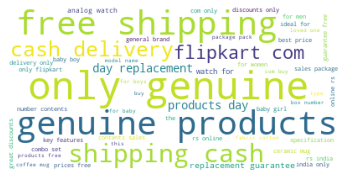

In [96]:
# Afficher le Wordclouds de description pour toutes les catégories
wordcloud = WordCloud(background_color="white",
                      stopwords=[],##Pas besoin d'enlever les stopwords/déjà fait
                      max_words=50).generate(" ".join(corpus))

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

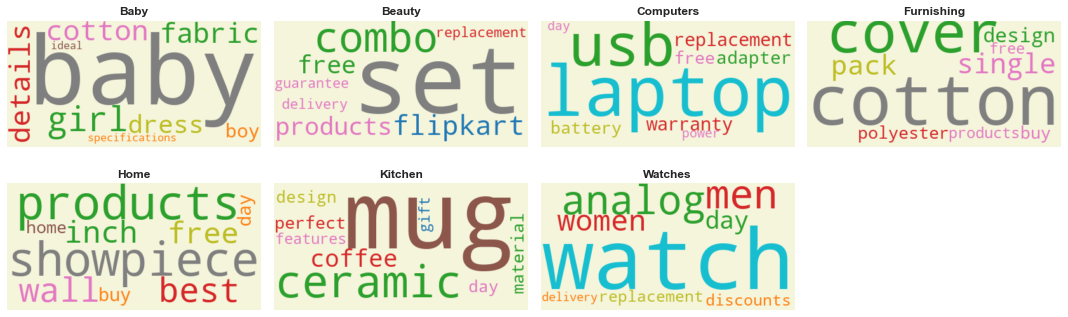

In [97]:
# Afficher le Wordclouds de description par catégorie 

gb = df.groupby('category')['description_bow']

plot_wordclouds_from_gb(gb, n_top_words=10, n_rows=2, figsize=(15,5),
                        backgnd_color='beige', cmap='tab10', random_state=14)

On constate des tokens qui se répétent : genuine, guarantee, warranty, flipkart, delivery, free, shipping, cash
On peut en supprimer une partie :  flipkart, delivery, free, shipping, cash, only, genuine
A ne pas supprimer : guarantee, warranty car liés à wtaches et computer

In [98]:
df.sample(5)

,category,description,description_bow,description_bow_lem,description_dl
uniq_id,,,,,
91a5328e7235424885d271dfa0959eeb,Kitchen,King International Ergonomic Design with Long Gripped Handle Rolling Pizza Cutter King Internati...,king international ergonomic design long gripped handle rolling pizza cutter king international ...,king international ergonomic design long grip handle roll pizza cutter king international ergono...,king international ergonomic design with long gripped handle rolling pizza cutter king internati...
9dc48a756ba86bbf6934ec6ddf9da03d,Computers,Lapguard HP Pavilion dv5-1014tx 6 Cell Laptop Battery Buy Lapguard HP Pavilion dv5-1014tx 6 Cell...,lapguard pavilion dv5 1014tx cell laptop battery buy lapguard pavilion dv5 1014tx cell laptop ba...,lapguard pavilion dv5 1014tx cell laptop battery buy lapguard pavilion dv5 1014tx cell laptop ba...,lapguard hp pavilion dv5 1014tx 6 cell laptop battery buy lapguard hp pavilion dv5 1014tx 6 cell...
63f6ef8f3fda2c306b27cfbf5a005f1e,Kitchen,Rockmantra Cute Beautiful Girl Playing With Her Hair Ceramic Mug Rockmantra Cute Beautiful Girl ...,rockmantra cute beautiful girl playing with her hair ceramic mug rockmantra cute beautiful girl ...,rockmantra cute beautiful girl play with her hair ceramic mug rockmantra cute beautiful girl pla...,rockmantra cute beautiful girl playing with her hair ceramic mug rockmantra cute beautiful girl ...
3830dda3491cd5b28ed42ae544bc44f0,Kitchen,Rockmantra Blue Water Abstracts Ceramic Mug Rockmantra Blue Water Abstracts Ceramic Mug (5.5 l)\...,rockmantra blue water abstracts ceramic mug rockmantra blue water abstracts ceramic mug 5.5 pric...,rockmantra blue water abstract ceramic mug rockmantra blue water abstract ceramic mug 5.5 price ...,rockmantra blue water abstracts ceramic mug rockmantra blue water abstracts ceramic mug ( 5.5 l ...
3aaa50eb5d2cf4c18b57346423871624,Baby,"Portia Hat Specifications of Portia Hat (Pink, Pack of 1) In The Box Number of Contents in Sales...",portia hat specifications portia hat pink pack the box number contents sales package pack genera...,portia hat specification portia hat pink pack the box number content sale package pack general i...,"portia hat specifications of portia hat ( pink , pack of 1 ) in the box number of contents in sa..."


#Sauvegardre le dataframe 
data.to_csv(path + '/cleaned/flipkart_com_cleaned.csv', index=False)# pour éviter d'avoir une colonne unamed=0, spécifier index=False

stop_cw =  ['flipkart', 'delivery', 'free', 'shipping', 'cash', 'delivery','only', 'genuine']

#Fonction qui filtre les mots à très haute fréquence
def stop_com_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_cw]
    return filtered_w

In [99]:
df.sample(2)

,category,description,description_bow,description_bow_lem,description_dl
uniq_id,,,,,
e1d8c5b60f9157f8e21c77cf795952f2,Baby,"The Intellect Bazaar Cotton Bath Towel, Baby Towel Buy The Intellect Bazaar Cotton Bath Towel, B...",the intellect bazaar cotton bath towel baby towel buy the intellect bazaar cotton bath towel bab...,the intellect bazaar cotton bath towel baby towel buy the intellect bazaar cotton bath towel bab...,"the intellect bazaar cotton bath towel , baby towel buy the intellect bazaar cotton bath towel ,..."
a3dea07b2f7bf48276d32513091be717,Kitchen,"BFT 6 W LED Bulb Key Features of BFT 6 W LED Bulb Pack of 1 Bulb,BFT 6 W LED Bulb (White) Price:...",bft led bulb key features bft led bulb pack bulb bft led bulb white price 350 introducing new te...,bft lead bulb key features bft lead bulb pack bulb bft lead bulb white price 350 introduce new t...,"bft 6 w led bulb key features of bft 6 w led bulb pack of 1 bulb , bft 6 w led bulb ( white ) pr..."


Opération de nettoyyage des mots qui se répèetent et qui n'apportnet rein aux catégories et pas d"apport séantique. Vréifier si répétitifs ds ttes les decr..
ex : shp, product, free
Le faire ultrieurement et comparer

# Bag of word - CountVectorizer et Tf-idf
## Vectorization CountVectorizer
transfomer les tokens en vecteurs
Each token is now represented by a unique vector and a text by a matrix
Each document is a row, and each token is a column. Such a matrix is called the document-term matrix.
It describes the frequency of terms that occur in a collection of documents and is used as input to a machine learning classifier.
Note that the size of the document-term matrix is: number of documents ∗ size of vocabulary

Convert a collection of text documents to a matrix of token counts.
chause token est reprsenté par un vecteur et chaque texte par une matrice
convertit un document texte en matrice avec le nombre de token
Il compte le nombre de fréquence des mots de chq document et le met dans la matrice
BOW : simple mais une puissante approche pour vectoriser le texte
----------------
Pour réduire les dimensions, dminuer le vocabulaire ou utliser une PCA

sparse matrix : matrice clairsemée : quand il a y trop de 0

### Vectorisation CountVectorizer exemple simple

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
corpus_test = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
X_test = vectorizer.fit_transform(corpus_test)
vectorizer.get_feature_names_out()

print(X_test.toarray())

#vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
#X2 = vectorizer2.fit_transform(corpus_test)
#vectorizer2.get_feature_names_out()

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [101]:
#Liste des mots 2à 2 ds le corpus
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(corpus_test)
vectorizer2.get_feature_names_out()

array(['and this', 'document is', 'first document', 'is the', 'is this',
       'second document', 'the first', 'the second', 'the third',
       'third one', 'this document', 'this is', 'this the'], dtype=object)

In [102]:
# les mots composants ce dictionnaire avec la fonction get_feature_names()
vectorizer.get_feature_names()

C:\Users\ADSL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

### Vectorisation du corpus

In [103]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

print(X.toarray()) #Transforme le corpus en array

# display the document-term matrix as a dataframe to show the tokens

#X2 = vectorizer2.fit_transform(corpus)
#vectorizer2.get_feature_names_out()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [104]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'description_bow_lem'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])  
ctf_transform = ctf.transform(df[feat])  

## Exécution des modèles

In [105]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.3913 time :  16.0

Tf-idf : 
--------
ARI :  0.5519 time :  14.0


CountVectorizer : 
-----------------
ARI :  0.3913 time :  16.0

Tf-idf : 
--------
ARI :  0.5519 time :  14.0

## Graphiques

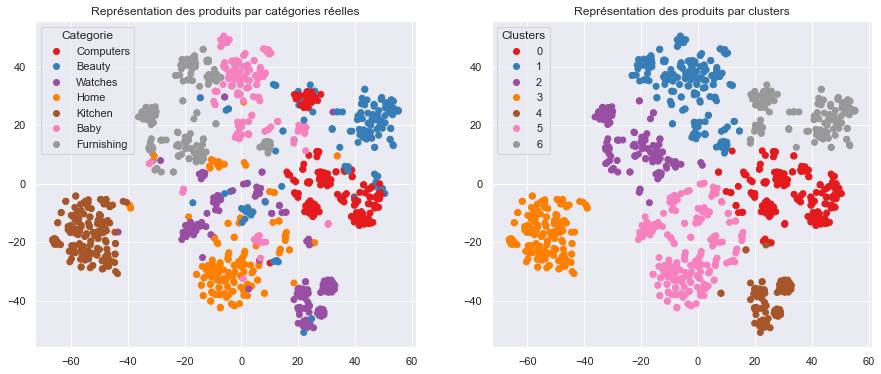

ARI :  0.5519


In [106]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)